# Advanced Lane Line Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images
- Apply a distortion correction to raw images
- Use color transforms, gradients, etc., to create a thresholded binary image
- Apply a perspective transform to rectify binary image ("birds-eye view")
- Detect lane pixels and fit to find the lane boundary
- Determine the curvature of the lane and vehicle position with respect to center
- Warp the detected lane boundaries back onto the original image
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

## Functions

The below functions are used throughout this project.

The write_rgb_image() function formats the image into RGB and then writes that image to the file destination provided.

The undistort_image() function will take the objectpoints and imagepoints and use them to correct the distortion caused by the camera lens.

The warp_image_to_birdseye_view() function will take the image, the destination points, and the image size and use them to change the perspective of the image to a bird's-eye view. This is done using the cv2.warpPerspective() method to change a forward facing image into a bird's eye view image when we feed it the destination points we calculated.

The get_warp_points() method gets the source and destination points for the perspective transform. This is important because it can be used to visualize the section of an image that we are going to augment, and what the dimensions will look like after we augment it, as seen below.

The get_thresholded_binary() method takes in an undistorted image and returns two images. One with the stacked color channels, and one without color but with the s_channel only. This is important because we can use these images to teach the model how to recognize lane lines using the "sobel x" that detects all the bright vertical lines in the image.

The find_lane_lines() function 

In [1]:
def write_rgb_image(image, filepath):
    # Convert image to RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # Write the rgb image to filepath
    cv2.imwrite(filepath, rgb_image)
    

def undistort_image(image, objectpoints, imagepoints):
    # Get image size
    img_size = (image.shape[1], image.shape[0])
    # Calibrate camera based on objectpoints, imagepoints, and image size
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, img_size, None, None)
    # Call cv2.undistort
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst


def warp_image_to_birdseye_view(image, src, dst, image_size):
    # Get perspective transform
    perspectiveTransform = cv2.getPerspectiveTransform(src, dst)
    # Warp perspective
    warped = cv2.warpPerspective(image, perspectiveTransform, image_size, flags=cv2.INTER_LINEAR)
    # Get the destination perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, perspectiveTransform, Minv


def get_warp_points(image):
    # Save corner values for source and destination partitions
    corners = np.float32([[253, 697], [585, 456], [700, 456], [1061, 690]])
    
    # Save top left and right explicitly and offset
    top_left = np.array([corners[0, 0], 0])
    top_right = np.array([corners[3, 0], 0])
    offset = [50, 0]
    
    # Get image size
    img_size = (image.shape[1], image.shape[0])
    
    # Save source points and destination points into arrays
    src_points = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst_points = np.float32([corners[0] + offset, top_left + offset, top_right - offset, corners[3] - offset])

    #print(src_points)
    #print(dst_points)
    
    return src_points, dst_points


def get_thresholded_binary(undistorted_image):
    # Convert undistorted image to HLS color space
    hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS).astype("float")
    
    # Get 's' channel
    s_channel = hls[:,:,2]
    
    # Get sobel x - the most vertical bright lines - and scale it
    gray = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Get threshold x gradient
    min_thresh = 20
    max_thresh = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= min_thresh) & (scaled_sobel <= max_thresh)] = 1
    
    # Get threshold for the 's' color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary


def find_lane_lines(warped_binary_image, testing=False):
    if testing == True:
        # Create an output image to draw on and visualize the result
        output_image = np.dstack((warped_binary_image, warped_binary_image, warped_binary_image))*255

    # Create histogram to find the lanes by identifying the peaks in the histogram
    histogram = np.sum(warped_binary_image[int(warped_binary_image.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    left_x_base = np.argmax(histogram[:midpoint])
    right_x_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    number_of_windows = 9
    # Set height of windows
    window_height = np.int(warped_binary_image.shape[0]/number_of_windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero_pixels = warped_binary_image.nonzero()
    nonzero_y_pixels = np.array(nonzero_pixels[0])
    nonzero_x_pixels = np.array(nonzero_pixels[1])
    
    # Current positions to be updated for each window
    left_x_current = left_x_base
    right_x_current = right_x_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(number_of_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary_image.shape[0] - (window+1)*window_height
        win_y_high = warped_binary_image.shape[0] - window*window_height
        win_x_left_low = left_x_current - margin
        win_x_left_high = left_x_current + margin
        win_x_right_low = right_x_current - margin
        win_x_right_high = right_x_current + margin
        
        if testing == True:
            # Draw the windows on the visualization image
            cv2.rectangle(output_image, (win_x_left_low,win_y_low), (win_x_left_high,win_y_high), (0,255,0), 2)
            cv2.rectangle(output_image, (win_x_right_low,win_y_low), (win_x_right_high,win_y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        left_inds = ((nonzero_y_pixels >= win_y_low) & (nonzero_y_pixels < win_y_high) & (nonzero_x_pixels >= win_x_left_low) & (nonzero_x_pixels < win_x_left_high)).nonzero()[0]
        right_inds = ((nonzero_y_pixels >= win_y_low) & (nonzero_y_pixels < win_y_high) & (nonzero_x_pixels >= win_x_right_low) & (nonzero_x_pixels < win_x_right_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(left_inds)
        right_lane_inds.append(right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left_inds) > minpix:
            left_x_current = np.int(np.mean(nonzero_x_pixels[left_inds]))
        if len(right_inds) > minpix:        
            right_x_current = np.int(np.mean(nonzero_x_pixels[right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    left_x = nonzero_x_pixels[left_lane_inds]
    left_y = nonzero_y_pixels[left_lane_inds] 
    right_x = nonzero_x_pixels[right_lane_inds]
    right_y = nonzero_y_pixels[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    # Generate x and y values for plotting
    plot_y = np.linspace(0, warped_binary_image.shape[0]-1, warped_binary_image.shape[0] )
    left_fit_x = left_fit[0]*plot_y**2 + left_fit[1]*plot_y + left_fit[2]
    right_fit_x = right_fit[0]*plot_y**2 + right_fit[1]*plot_y + right_fit[2]
    
    # Get binary warped image size
    image_size = warped_binary_image.shape
    
    # Get max of plot_y
    y_eval = np.max(plot_y)
    
    # Define conversions in x and y from pixels space to meters
    y_m_per_pix = 30/720
    x_m_per_pix = 3.7/700
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*y_m_per_pix, left_x*x_m_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*y_m_per_pix, right_x*x_m_per_pix, 2)
    
    # Calculate radius of curve
    left_curve = ((1+(2*left_fit_cr[0]*y_eval*y_m_per_pix+left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curve = ((1+(2*right_fit_cr[0]*y_eval*y_m_per_pix+right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
    
    # Calculate lane deviation from center of lane
    scene_height = image_size[0] * y_m_per_pix
    scene_width = image_size[1] * x_m_per_pix
    
    # Calculate the intercept points at the bottom of our image
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    center = (left_intercept + right_intercept) / 2.0
    
    # Use intercept points to calculate the lane deviation of the vehicle
    lane_deviation = (center - scene_width / 2.0)
    
    if testing == True:
        output_image[nonzero_y_pixels[left_lane_inds], nonzero_x_pixels[left_lane_inds]] = [255, 0, 0]
        output_image[nonzero_y_pixels[right_lane_inds], nonzero_x_pixels[right_lane_inds]] = [0, 0, 255]
        return left_fit_x, right_fit_x, plot_y, left_fit, right_fit, left_curve, right_curve, lane_deviation, output_image
    else:
        return left_fit_x, right_fit_x, plot_y, left_fit, right_fit, left_curve, right_curve, lane_deviation


def draw_lane_lines(warped_binary_image, undistorted_image, Minv, left_fitx, right_fitx, ploty, left_radius, right_radius, lane_deviation):
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(warped_binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    unwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_image.shape[1], undistorted_image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, unwarp, 0.3, 0)
    
    # Write text on image
    curvature_text = "Curvature: Left = " + str(np.round(left_radius, 2)) + ", Right = " + str(np.round(right_radius, 2))
    font = cv2.FONT_HERSHEY_TRIPLEX    
    cv2.putText(result, curvature_text, (30, 60), font, 1, (0,255,0), 2)
    deviation_text = "Lane deviation from center = {:.2f} m".format(lane_deviation) 
    font = cv2.FONT_HERSHEY_TRIPLEX
    cv2.putText(result, deviation_text, (30, 90), font, 1, (0,255,0), 2)
        
    return result


def process_image(image):
    undistorted = undistort_image(image, objpoints, imgpoints)
    _, combined_binary = get_thresholded_binary(undistorted)
    src, dst = get_warp_points(image)
    binary_warped, _, Minv = warp_image_to_birdseye_view(combined_binary, src, dst, (image.shape[1], image.shape[0]))
    left_fitx, right_fitx, ploty, _, _, l, r, d = find_lane_lines(binary_warped)
    lane_lines_img = draw_lane_lines(binary_warped, undistorted, Minv, left_fitx, right_fitx, ploty, l, r, d)
    return lane_lines_img

## Calibrating The Camera

We calibrate the camera to eliminate any distortion caused by the camera lens. Below you can see a visualization of the distorted images before we calibrate the camera.

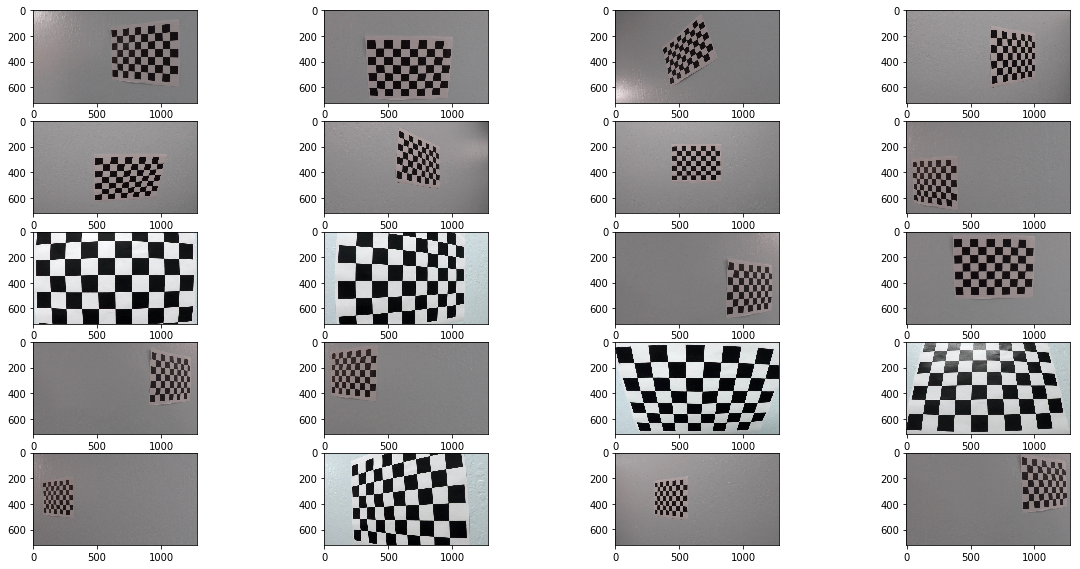

In [2]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Get all calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# For each image, plot it below
plt.figure(figsize=(20, 20))
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    plt.subplot(len(images)//2, 4, i+1)
    plt.imshow(img)

## Finding The Corners Of The Chess Board

In the cell below I use the openCV function findChessboardCorners() to detect the corners of ever square in on a chessboard. The reason I am interested in finding these corners is because it will allow me to undistort this image later on in the project.

I prepare "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained the result below.

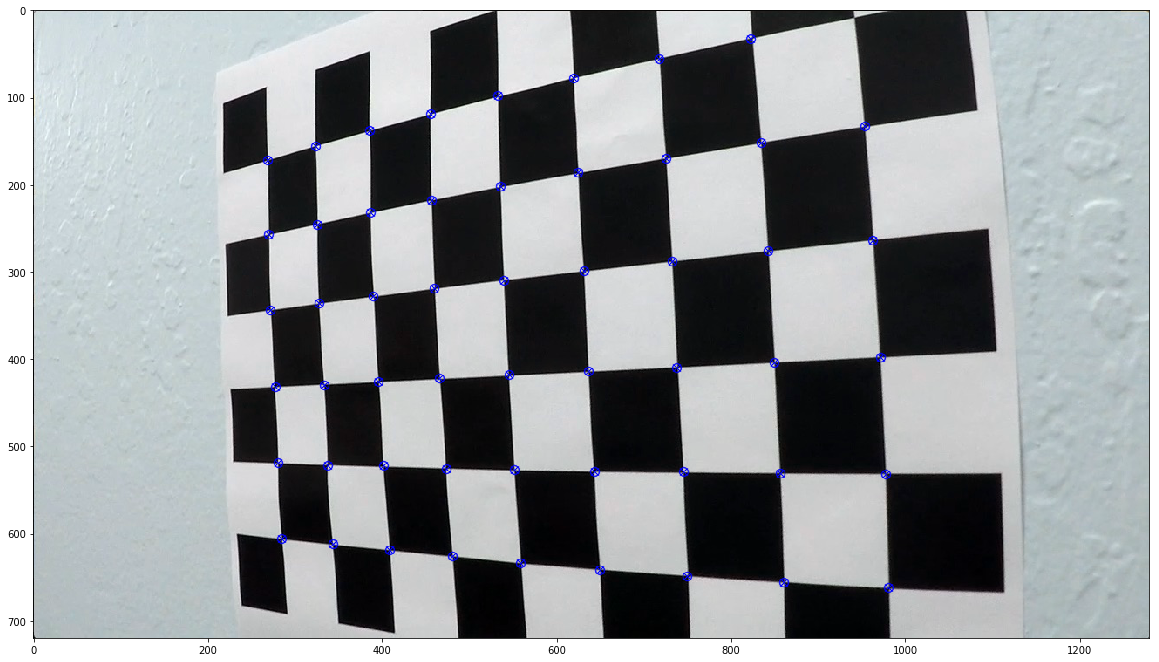

In [3]:
# Get object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Store object points and image points from all the images
objpoints = []
imgpoints = []

# Get list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# For each image, find corners and add points to arrays
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
# Print one example of the found corners
img = cv2.imread("camera_cal/calibration4.jpg")

# Find corners
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

# Draw corners
cv2.drawChessboardCorners(img, (9, 6), corners, ret)

# Plot image
plt.figure(figsize=(20, 20))
plt.imshow(img)

# Write out file
write_rgb_image(img, "output_files/img_with_highlighted_corners.jpg")

## Undistorting The Image

Using the corners I found I can undistort the image to make the edges of the chess board straight instead of curved. The curve that you can see in the above image is caused by the camra lens that distorts the image.

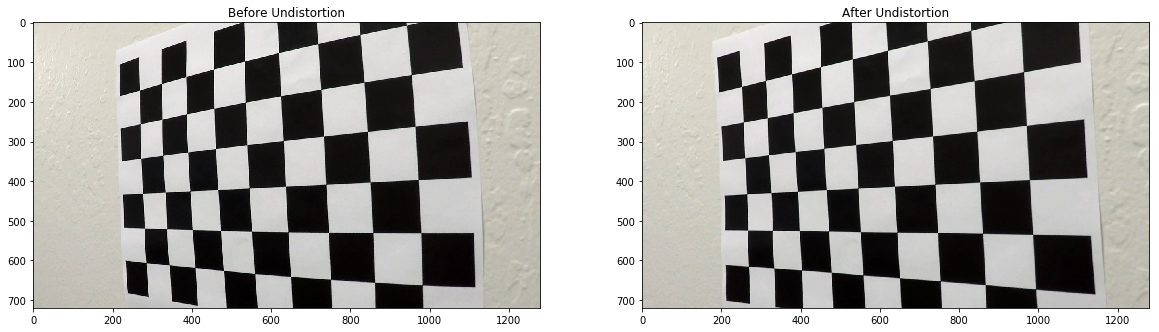

In [4]:
# Read in image
img = cv2.imread("camera_cal/calibration4.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
# Undistort image given object points and image points
dst = undistort_image(img, objpoints, imgpoints)

# Plot before undistortion
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Before Undistortion")

# Plot after undistortion
plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.title("After Undistortion");

# Write out image
write_rgb_image(dst, "output_files/camera_calibration.jpg")

## Undistorting Picture Of The Road

Now that we have proved that we can undistort images using the above functions, we can now focus on undistorting images taken from the front of a car. This is important because we want to give the car an accurate representation of the world around it so it can better make decisions.

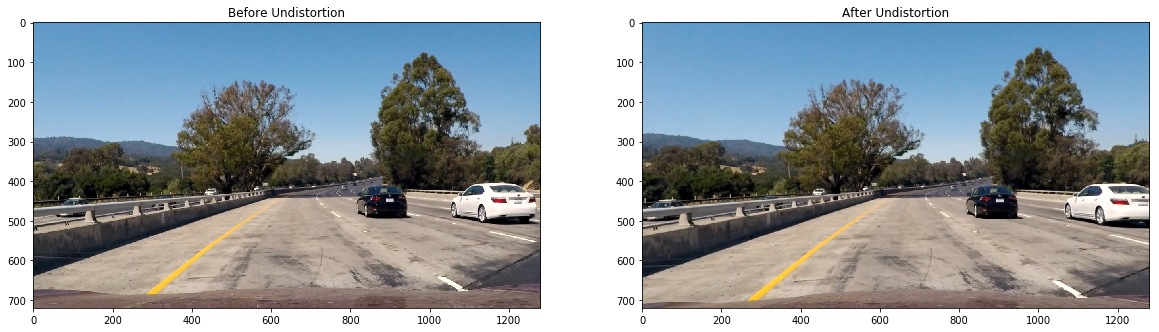

In [5]:
# Read in image
test_img = cv2.imread("test_images/test1.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# Undistory image
test_dst = undistort_image(test_img, objpoints, imgpoints)

# Plot before undistortion image
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Before Undistortion")

# Plot after undistortion image
plt.subplot(1, 2, 2)
plt.imshow(test_dst)
plt.title("After Undistortion");

# Write out image
write_rgb_image(test_dst, "output_files/undistort_test_image.jpg")

# Perspective Transform

Source Points:
[[[ 253  697]]

 [[ 585  456]]

 [[ 700  456]]

 [[1061  690]]]

Destination Points:
[[[ 303  697]]

 [[ 303    0]]

 [[1011    0]]

 [[1011  690]]]


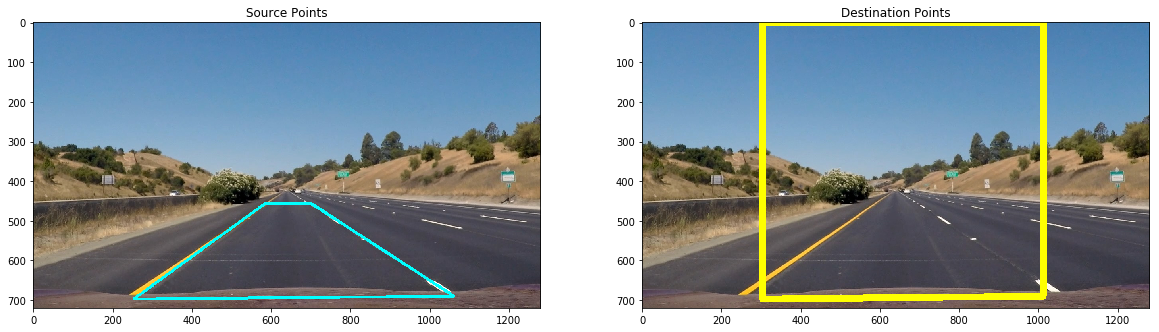

In [6]:
# Read in image and get warp points for the image
image = cv2.imread("test_images/straight_lines1.jpg")
src, dst = get_warp_points(image)

# Get source and destination points on the original image
points_image_src = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
points_image_dst = points_image_src.copy()

# Make a polygon based on source points and draw it on the image
src_pts = src.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_src, [src_pts], True, (0, 255, 255), thickness=5)

# Plot source image
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(points_image_src)
plt.title("Source Points")
write_rgb_image(points_image_src, "output_files/source_points.jpg")

# Make a polygon based on destination points and draw it on the image
dst_pts = dst.reshape((-1, 1, 2)).astype("int32")
cv2.polylines(points_image_dst, [dst_pts], True, (255, 255, 0), thickness=15)

# Print out source and destination points
print("Source Points:")
print(src_pts)
print()
print("Destination Points:")
print(dst_pts)

# Plot destination image
plt.subplot(1, 2, 2)
plt.imshow(points_image_dst)
plt.title("Destination Points")
write_rgb_image(points_image_dst, "output_files/destination_points.jpg");

## Test Warping To Bird's-eye View For Straight & Curved Images

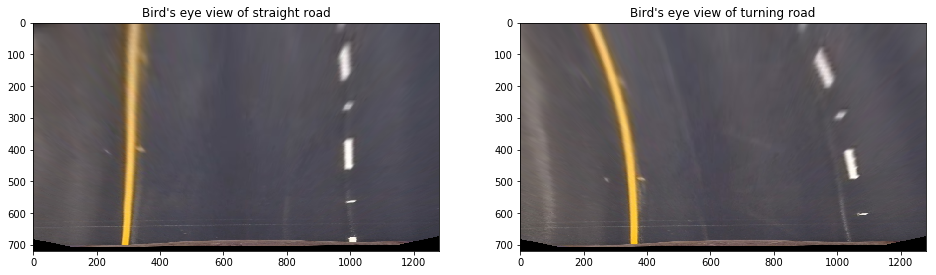

In [7]:
# Read in the same test image as used above and plot
image = cv2.imread("test_images/straight_lines1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Warp straight road image into bird's-eye view
image = undistort_image(image, objpoints, imgpoints)
src, dst = get_warp_points(image)
warped, _, _ = warp_image_to_birdseye_view(image, src, dst, (image.shape[1], image.shape[0]))
write_rgb_image(warped, "output_files/warped_test_straight.jpg")

# Plot bird's-eye view of straight road
plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(warped)
plt.title("Bird's eye view of straight road");

# Read in an image with straight lane lines to check the warped lines are parallel
image2 = cv2.imread("test_images/test2.jpg")
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Warp curved road image into bird's-eye view
image2 = undistort_image(image2, objpoints, imgpoints)
warped2, _, _ = warp_image_to_birdseye_view(image2, src, dst, (image2.shape[1], image2.shape[0]))
write_rgb_image(warped2, "output_files/warped_test_curved.jpg")

# Plot curved road bird's-eye view
plt.subplot(1, 2, 2)
plt.imshow(warped2)
plt.title("Bird's eye view of turning road")

## Print Out Different Color Thresholds

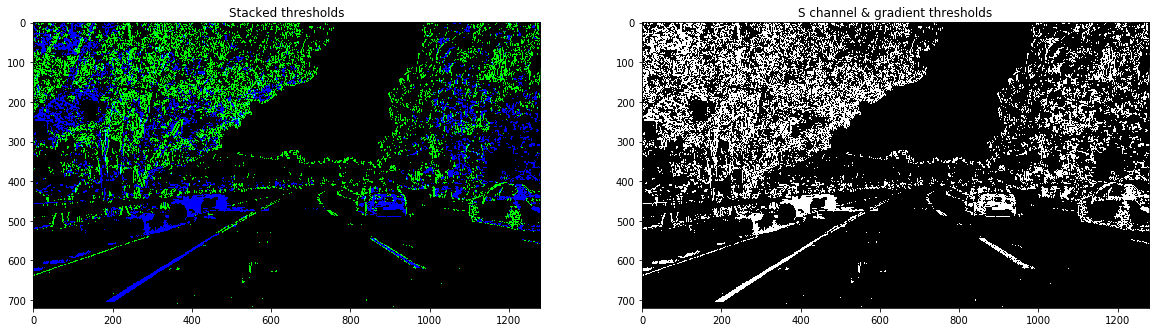

In [8]:
# Read in image
img = cv2.imread("test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Undistort image and get the binary versions of the image
undistorted_img = undistort_image(img, objpoints, imgpoints)
color_binary, combined_binary = get_thresholded_binary(undistorted_img)

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)

# Save image
binary = 255 * color_binary.astype("uint8")
binary = cv2.cvtColor(binary, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_files/color_binary.jpg", binary)

# Plot image
ax2.set_title("S channel & gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")

# Save image
binary = 255 * combined_binary.astype("uint8")
cv2.imwrite("output_files/combined_binary.jpg", binary);

## Test Warping Image To Bird's-eye View

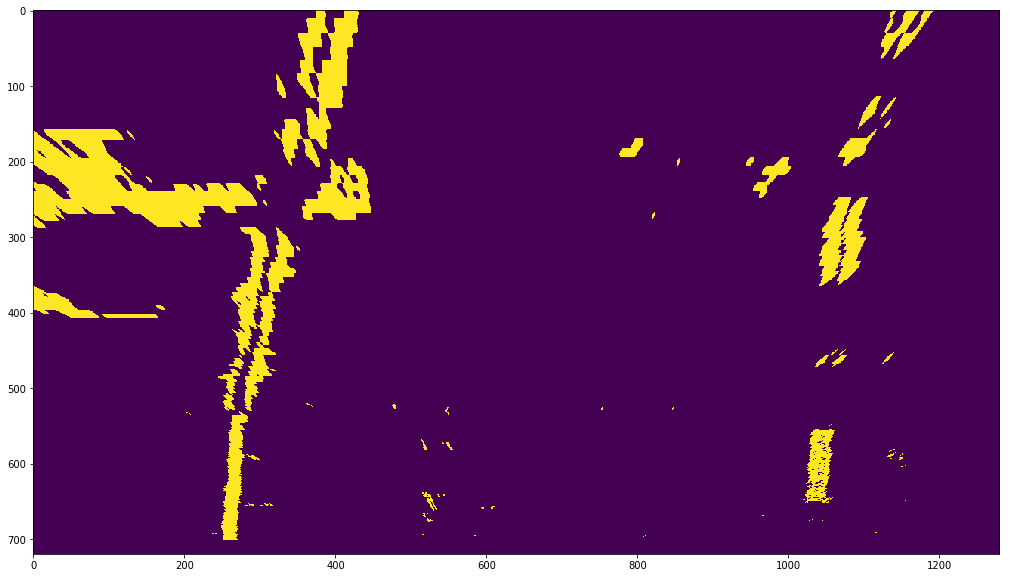

In [9]:
# Warp image to bird's-eye view and plot
warped_binary_image, _, Minv = warp_image_to_birdseye_view(combined_binary, src, dst, (image.shape[1], image.shape[0]))
plt.figure(figsize=(20,10))
plt.imshow(warped_binary_image)

# Save
binary = 255 * warped_binary_image.astype("uint8")
cv2.imwrite("output_files/binary_warped.jpg", binary);

## Output Histogram Showing Where Lines Are In Image

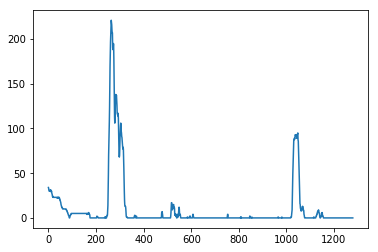

In [10]:
# Take a histogram of the bottom half of the image
histogram = np.sum(warped_binary_image[int(warped_binary_image.shape[0]/2):,:], axis=0)
plt.plot(histogram);

## Test find_lane_lines() function

(720, 0)

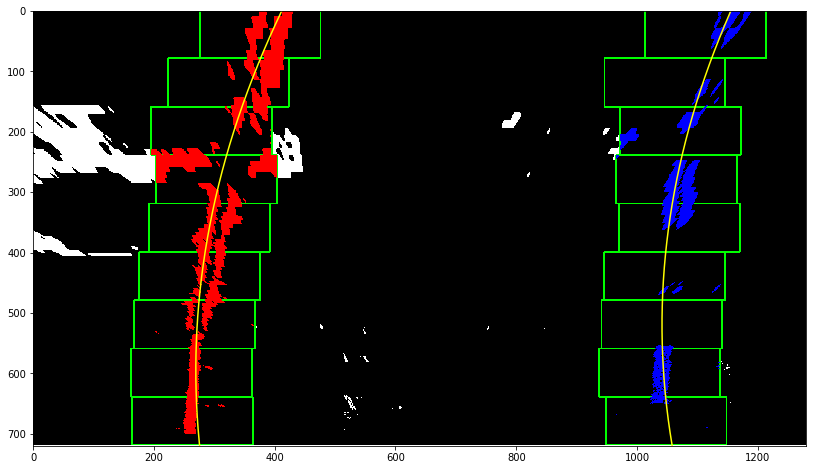

In [11]:
# Test the find_lane_lines function on test image
left_fitx, right_fitx, ploty, left_fit, right_fit, l, r, d, out_img = find_lane_lines(warped_binary_image, testing=True)

# Plot the image
plt.figure(figsize=(16,8))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Test Draw Lane Lines On Real Image

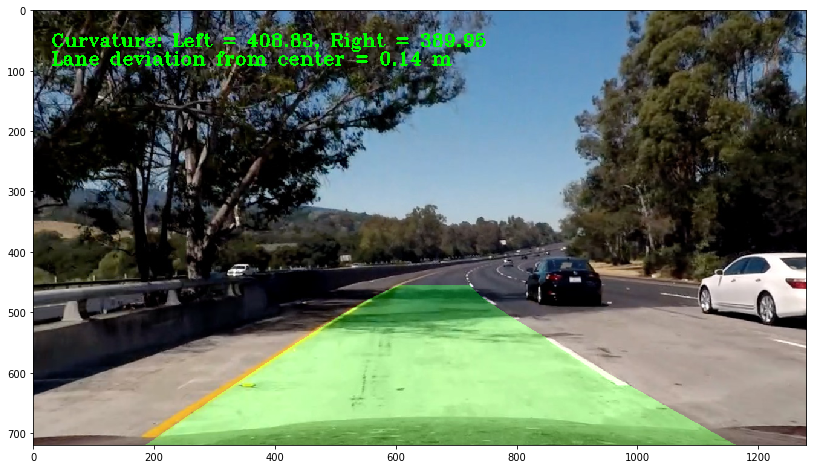

In [12]:
result = draw_lane_lines(warped_binary_image, undistorted_img, Minv, left_fitx, right_fitx, ploty, l, r, d)
plt.figure(figsize=(16,8))
plt.imshow(result)
write_rgb_image(result, "output_files/highlighted_lane.jpg")

## Try Pipeline On Real Image

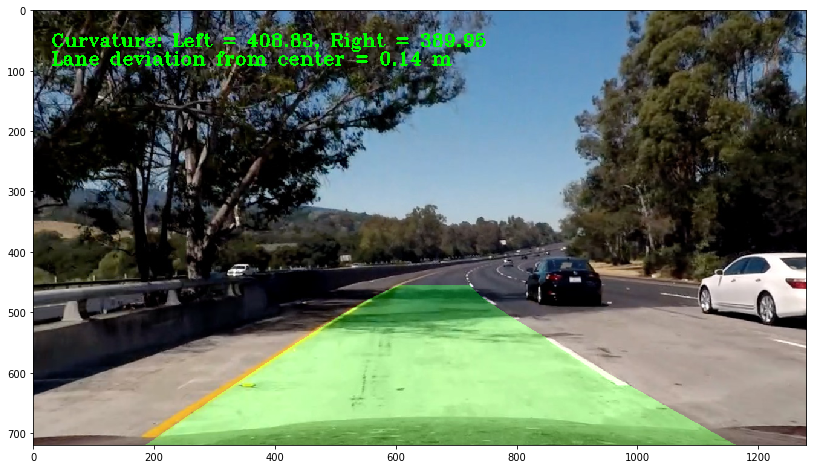

In [13]:
img = cv2.imread("test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

result = process_image(img)

plt.figure(figsize=(16,8))
plt.imshow(result)

write_rgb_image(result, "output_files/highlighted_curved_lane.jpg")

## Given a video taken from the front of a car driving, this is my model's output

In [14]:
video_output = "output_files/project_video.mp4"
clip1 = VideoFileClip("test_videos/project_video.mp4")
clip1_output = clip1.fl_image(process_image)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_files/project_video.mp4
[MoviePy] Writing video output_files/project_video.mp4


100%|█████████▉| 1260/1261 [14:30<00:00,  1.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_files/project_video.mp4 

CPU times: user 18min 15s, sys: 9.51 s, total: 18min 24s
Wall time: 14min 30s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))